In [7]:
"""

Pre-train a CNN on the whole dataset for evaluation purpose

"""
import os
import argparse
import shutil
import os
import timeit
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch import autograd
from torchvision.utils import save_image
import csv
from tqdm import tqdm
import gc
import h5py

import copy
import eagerpy as ep

model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all


import foolbox as fb
from foolbox.attacks import LinfPGD


In [8]:
device = torch.device("cuda:0")
netG_checkpoint = torch.load("./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=162000.pth", map_location=device)
netG = model_all.get_generative_model("CIFAR10")
netG.load_state_dict(netG_checkpoint['state_dict'])
netG = netG.to(device)
netG.eval()
print("go")
# 提前加载预处理的数据（降维后的2维坐标和对应的高维向量）
tree_2D_path="./static/data/CIFAR10/2D_kdTree/2D_kdTree_200000.pt"
data_z_path="./static/data/CIFAR10/latent_z/BigGAN_208z_200000.pt"

tree_2D = torch.load(tree_2D_path)
dict_zs = torch.load(data_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错

go


In [9]:
# 通过对抗扰动获取图片真实的鲁棒性
def adversarial_robustness(model, image_path, label, device):
    print("获取对抗鲁棒性中.....")
    sys.stdout.flush()
    time1 = time.time()

    transform = transforms.Compose(
            [
                transforms.ToTensor()
            ]
        )
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # 增加一个维度维batch维度
    copy_model = copy.deepcopy(model)
    copy_model.eval()
    preprocessing = dict(mean=[0.4914,0.4822,0.4465], std=[0.2023,0.1994,0.2010], axis=-3)
    bounds = (0, 1)
    fmodel = fb.PyTorchModel(copy_model, bounds=bounds, device = device, preprocessing=preprocessing)
    attack = fb.attacks.LinfPGD()
    epsilon = 0.001
    # 直到出现对抗样本为止
    flag = False
    while(flag == False):
        if epsilon >= 0.033:
            break
        raw_advs, clipped_advs, success = attack(fmodel, image, label, epsilons=epsilon)
        flag=success
        epsilon = epsilon + 0.001

    sys.stdout.flush()
    time2 = time.time()
    print("获取对抗鲁棒性消耗时间：", time2-time1)
    return epsilon-0.001

In [10]:
# 想办法防止近邻的点粘在一块 效果最好的！！！！！！！！
def get_zs_prevent_stick(coordinates, kdTree_2D, latent_z, k=20):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~;k=",k)
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

进入了防止粘在一块~~~~~~~~~~~~~~~~~~;k= 20
进入了防止粘在一块~~~~~~~~~~~~~~~~~~;k= 20


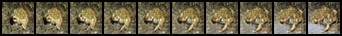

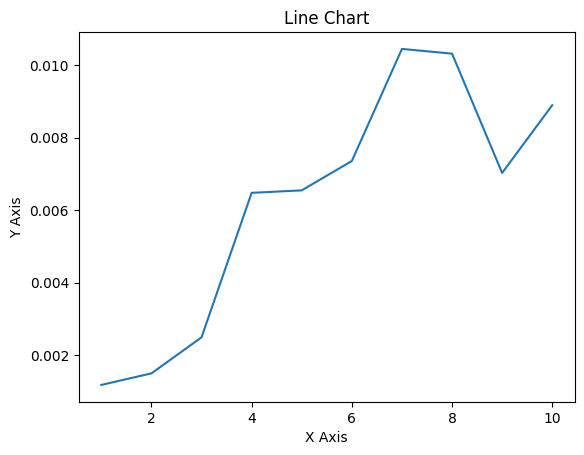

In [19]:
cor1 = [-29.666848000987503, -43.54958023051247]
cor2 = [-29.764043325814985, -43.5698292565182]

z_and_embed1 = get_zs_prevent_stick([cor1], tree_2D, dict_zs).squeeze(0)
z_and_embed2 = get_zs_prevent_stick([cor2], tree_2D, dict_zs).squeeze(0)


inter_number = 10

# z_and_embed2[256:] = label #替换z2中的label
# 插值inter_number个
interpolated_z_and_embed = torch.zeros((inter_number, z_and_embed1.shape[0]))  # 初始化插值数组
for i in range(inter_number):
    interpolated_z_and_embed[i] = z_and_embed1 * (inter_number - i - 1) / (inter_number - 1) + z_and_embed2 * i / (inter_number - 1)

interpolated_z_and_embed = interpolated_z_and_embed.to(device)
fake_images = netG(interpolated_z_and_embed)
temp_images = fake_images
import torchvision.utils as vutils

# 将 fake_images 转换为可视化的图片，需要将像素值从 [-1, 1] 转换到 [0, 1] 的范围内
fake_images = (fake_images + 1) / 2

# 将 fake_images 保存到文件中
vutils.save_image(fake_images, 'generated_images.png', nrow=inter_number, normalize=True)

from IPython.display import Image

# 读取生成的图片
generated_image = Image(filename='generated_images.png', width=512, height=512)

# 显示图片
display(generated_image)

# 模型加载
dataset_type = "CIFAR10"
model_name = "MobileNetV2_x1_4"
DNN_model = model_all.get_DNN_model(dataset_type, model_name)
DNN_model.load_state_dict(torch.load("./model_files/" + dataset_type + "/checkpoints/classify_model/" + model_name + ".pt", map_location=device))
DNN_model = DNN_model.to(device)
DNN_model.eval()
rob_predictor = model_all.get_rob_predictor(dataset_type, model_name)
rob_predictor.load_state_dict((torch.load("./model_files/"+ dataset_type + "/checkpoints/rob_predictor/kjl_rob_predictor_" + model_name + ".pt", map_location=device)))
rob_predictor = rob_predictor.to(device)
rob_predictor.eval()

# 定义中间变量字典
activation = {}
# 用来获取模型中间层输出的hook
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

if dataset_type == "CIFAR10":
    imgs = netG(interpolated_z_and_embed)   
    layers = DNN_model(imgs) #分类模型分类图片
    label = torch.argmax(layers, dim=1)
elif dataset_type == "SteeringAngle":
    imgs = netG(interpolated_z_and_embed[:, :256], interpolated_z_and_embed[:, 256:])
    # 注册钩子函数到第二层
    DNN_model.pool1.register_forward_hook(get_activation('pool1'))
    label = DNN_model(imgs)
    layers = activation['pool1']
    layers = layers.view(layers.size(0), -1)

robustness = rob_predictor(layers) #鲁棒性预测网络预测图片
data = robustness.detach().cpu()

# robustness = []
# for i in range(inter_number):
#     robustness.append(adversarial_robustness_regre(DNN_model, temp_images[i], label[i], device))
#     data = robustness
# print(robustness)


# 生成x坐标轴数据
x = np.arange(1, inter_number+1)
# 绘制折线图
plt.plot(x, data)
# 添加标题和轴标签
plt.title('Line Chart')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# 显示图形
plt.show()